# Ridge regression using grid search CV 


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.metrics import make_scorer

In [31]:
# Defining different measures to evaluate performance 
# MAPE
def mean_absolute_percentage_error(y_true, y_pred, eps = 1e-8): 
    return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100 

mape = make_scorer(mean_absolute_percentage_error, 
                   greater_is_better=False)

# SMAPE
def symmetric_mape(y_true, y_pred, eps = 1e-8):
    summ = ((np.abs(y_true) + np.abs(y_pred)) + eps)
    return np.mean(np.abs(y_pred - y_true) / summ) * 100

smape = make_scorer(symmetric_mape, 
                    greater_is_better=False)

def print_scores(y_test, y_pred):
    print(f"R2 score: {r2_score(y_test, y_pred)}")
    print(f"MSE score: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE score: {mean_absolute_error(y_test, y_pred)}")
    print(f"Median AE score: {median_absolute_error(y_test, y_pred)}")
    print(f"MAPE score: {mean_absolute_percentage_error(y_test, y_pred)}")
    print(f"SMAPE score: {symmetric_mape(y_test, y_pred)}")

In [32]:
# Load in the time series
candy = pd.read_csv('dfV2.csv')
# Set the index equal to time stamp
candy["Unnamed: 0"] = pd.to_datetime(candy["Unnamed: 0"])
candy = candy.set_index('Unnamed: 0')


In [33]:
# Split the data into a train and test set
df_train, df_test = candy.iloc[:-10000], candy.iloc[-10000:]

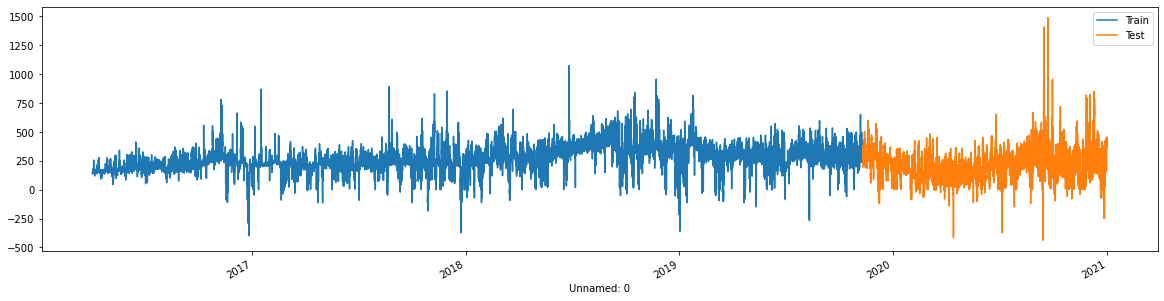

In [34]:
# Create plot visualizing the train and test data 

# Create an axis
fig, ax = plt.subplots(figsize = (20,5))

# Plot the train and test setsa dn show
df_train["DK1"].plot(ax=ax)
df_test["DK1"].plot(ax=ax)
#plt.axvline(x=4000, color='k', linestyle='--')
ax.legend(["Train", "Test"]);
plt.show()

In [35]:
# Create arrays for X and y for both training and testing data set. 
y_train = df_train[["DK1"]].to_numpy()
y_test  = df_test[["DK1"]].to_numpy()

X_train = df_train.copy()
X_test  = df_test.copy()

X_train.drop('DK1', inplace=True, axis=1)
X_test.drop('DK1', inplace=True, axis=1)

X_train = X_train.to_numpy()
X_test  = X_test.to_numpy()

In [36]:
# Define the pipeline for the Lasso regression
pipe_ridge = Pipeline([
                       #('polynomial', PolynomialFeatures(degree = 2, include_bias=True, interaction_only=True)),
                       ('scale', StandardScaler()),
                       ('ridge', Ridge())
                       ])

# Set the different values of lambdas to be searched through in the CV
params_ridge = {'ridge__alpha': np.logspace(-4,1,10)}

In [37]:
# Define the type of cross validation used in the grid search. The TimesSeriesSplit 
# is the k-fold alternative for times series keeping the natural order in the data 
# i.e. one avoid using future observations to predict the past. 
ts_cv = TimeSeriesSplit(n_splits=10).split(X_train)

# Define the pipeline for the grid search using the LASSO pipeline and defined type of CV.
# Further, we apply the relevant scoring and parallelizes the CV
gs_ridge = GridSearchCV(pipe_ridge,
                        param_grid=params_ridge,
                        scoring='neg_mean_absolute_error',
                        cv=ts_cv,
                        n_jobs=4)

In [38]:
# Show which observations that go into train and validation sets
# ts_cv = TimeSeriesSplit(n_splits=15, test_size=1)
# for train_index, test_index in ts_cv.split(X_train):
#     print("TRAIN:", train_index, "TEST:", test_index)


In [39]:
# Using the defined pipeline to fit our training set
gs_ridge.fit(X_train,y_train)
# And predicting using the LASSO regression model and the test data 
y_pred_ridge = gs_ridge.predict(X_test)

<ipython-input-40-cc4876050ce1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["pred"] = y_pred_ridge


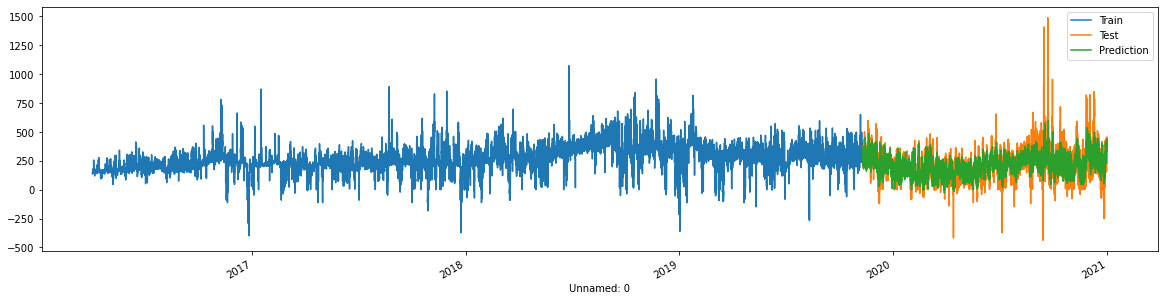

In [40]:
# Plot the actual values (train and test) and predicted valuesw
fig, ax = plt.subplots(figsize = (20,5))

df_train["DK1"].plot(ax=ax)
df_test["DK1"].plot(ax=ax)

df_test["pred"] = y_pred_ridge
df_test["pred"].plot(ax=ax)

ax.legend(["Train","Test","Prediction"]);
plt.show()

In [41]:
# Optimal lambda value from the grid search
print(f"Optimal lambda value in ridge using grid search: {gs_ridge.best_params_}")

# Different scoring values
print_scores(y_test, y_pred_ridge)

Optimal lambda value in ridge using grid search: {'ridge__alpha': 10.0}
R2 score: 0.6898586326197875
MSE score: 5201.86282947534
MAE score: 52.391296014685615
Median AE score: 40.36814288227279
MAPE score: inf
SMAPE score: 20.00337586044769


<ipython-input-31-8fecfd3bbe5b>:4: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100


In [52]:
# Defining the final pipeline using the optimal lambda detected from the grid search 
finalpipe_ridge = Pipeline([
                       #('polynomial', PolynomialFeatures(degree = 2, include_bias=True, interaction_only=True)),
                       ('scale', StandardScaler()),
                       ('ridge', Ridge(alpha = gs_ridge.best_params_["ridge__alpha"]))
                       ])

# Fitting the training data and predicting on the test data
finalpipe_ridge.fit(X_train,y_train)
finalpipe_ridge.predict(X_test)
len(list(finalpipe_ridge.named_steps['ridge'].coef_.T))

101

In [56]:
# Save coefficients to a dictionary
candy.drop("DK1", inplace = True, axis = 1)
d = {}
for i in range(len(candy.columns)):
    d[candy.columns[i]] = list(finalpipe_ridge.named_steps['ridge'].coef_.T)[i][0]


In [57]:
d

{'cloud_cover': -0.424536678866396,
 'temp_soil_max_past1h': 12.81749460146537,
 'wind_max_per10min_past1h': -1.502787025356264,
 'acc_precip': -1.4638012502037923,
 'bright_sunshine': 3.7802209527628903,
 'mean_pressure': 0.5457702659265996,
 'mean_radiation': -12.273523798105385,
 'mean_relative_hum': -0.861868276861614,
 'mean_temp': -2.0626115722543448,
 'mean_wind_dir': -0.8994228456178229,
 'mean_wind_speed': -0.07692292328060876,
 'temp_grass': 1.713314528644108,
 'DK1_CP': 24.805126188535468,
 'DK2_CP': 7.9296286559552565,
 'DK1_PP': 26.54553007425577,
 'DK2_PP': 5.44606939722029,
 'DK1_WP': -27.184826305499254,
 'DK2_WP': -13.712107366478364,
 'hour_1': 0.8291997170170998,
 'hour_2': 0.7713109005190121,
 'hour_3': 0.4082503337493385,
 'hour_4': -0.07100399449317976,
 'hour_5': -0.48245270404616736,
 'hour_6': -0.6729591350126615,
 'hour_7': 0.171538131832002,
 'hour_8': 0.2023603113618104,
 'hour_9': -0.5611601033933968,
 'hour_10': -2.4139507608421344,
 'hour_11': -3.72390679